### Music Recommendation Sandbox

In [42]:
import numpy as np
import pandas as pd

# SKLEARN
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

In [43]:
INPUT_DATA_PATH = '/Users/youngtodd/kbox_music_kaggle/data/'

df_test = pd.read_csv(INPUT_DATA_PATH + 'test.csv',dtype={'msno' : 'category',
                                                          'source_system_tab' : 'category',
                                                          'source_screen_name' : 'category',
                                                          'source_type' : 'category',
                                                          'song_id' : 'category'})

df_train = pd.read_csv(INPUT_DATA_PATH + 'train.csv',dtype={'msno' : 'category',
                                                            'source_system_tab' : 'category',
                                                            'source_screen_name' : 'category',
                                                            'source_type' : 'category',
                                                            'target' : np.uint8,
                                                            'song_id' : 'category'})

df_members = pd.read_csv(INPUT_DATA_PATH + 'members.csv',dtype={'city' : 'category',
                                                                'bd' : np.uint8,
                                                                'gender' : 'category',
                                                                'registered_via' : 'category'},
                                                                parse_dates=['registration_init_time','expiration_date'])

# Load the songs dataframe
df_songs = pd.read_csv(INPUT_DATA_PATH + 'songs.csv',dtype={'genre_ids': 'category',
                                                            'language' : 'category',
                                                            'artist_name' : 'category',
                                                            'composer' : 'category',
                                                            'lyricist' : 'category',
                                                            'song_id' : 'category'})

In [44]:
songs_extra = pd.read_csv(INPUT_DATA_PATH + 'song_extra_info.csv')

def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

df_train = df_train.merge(songs_extra, on = 'song_id', how = 'left')
df_test = df_test.merge(songs_extra, on = 'song_id', how = 'left')


In [45]:
# Convert date to number of days
df_members['membership_days'] = (df_members['expiration_date'] - df_members['registration_init_time']).dt.days.astype(int)

# Remove both date fieldsa since we already have the number of days between them
df_members = df_members.drop(['registration_init_time','expiration_date'], axis=1)

In [46]:
# Merge the members dataframe into the test dataframe
df_test = pd.merge(left = df_test,right = df_members,how='left',on='msno')
df_test.msno = df_test.msno.astype('category')

# Merge the member dataframe into the train dataframe
df_train = pd.merge(left = df_train,right = df_members,how='left',on='msno')
df_train.msno = df_train.msno.astype('category')

# Release memory
del df_members

# Merge the Test Dataframe with the SONGS dataframe
df_test = pd.merge(left = df_test,right = df_songs,how = 'left',on='song_id')
df_test.song_length.fillna(200000,inplace=True)
df_test.song_length = df_test.song_length.astype(np.uint32)
df_test.song_id = df_test.song_id.astype('category')

# Merge the Train dataframe with the SONGS dataframe
df_train = pd.merge(left = df_train,right = df_songs,how = 'left',on='song_id')
df_train.song_length.fillna(200000,inplace=True)
df_train.song_length = df_train.song_length.astype(np.uint32)
df_train.song_id = df_train.song_id.astype('category')

# Release memory
del df_songs

In [36]:
train_rows = len(df_train) - len(df_test)

val = df_train.tail(len(df_test))
train = df_train.head(train_rows)

In [47]:
import lightgbm as lgb

In [48]:
# Create a Cross Validation with 3 splits
kf = KFold(n_splits=4)

# This array will store the predictions made.
predictions = np.zeros(shape=[len(df_test)])

# For each KFold
for train_indices ,validate_indices in kf.split(df_train) : 
    train_data = lgb.Dataset(df_train.drop(['target'],axis=1).loc[train_indices,:],label=df_train.loc[train_indices,'target'])
    val_data = lgb.Dataset(df_train.drop(['target'],axis=1).loc[validate_indices,:],label=df_train.loc[validate_indices,'target'])
    

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'learning_rate': 0.1 ,
        'verbose': 0,
        'num_leaves': 90,
        'bagging_fraction': 0.90,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 128,
        'max_depth': 8,
        'num_rounds': 200,
        'metric' : 'auc',
        } 
 
    # Train the model
    bst = lgb.train(params, train_data, 100, valid_sets=[val_data])
    
    # Make the predictions storing them on the predictions array
    predictions += bst.predict(df_test.drop(['id'],axis=1))

/Users/youngtodd/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:98: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.687584
[2]	valid_0's auc: 0.693987
[3]	valid_0's auc: 0.703737
[4]	valid_0's auc: 0.709925
[5]	valid_0's auc: 0.712762
[6]	valid_0's auc: 0.713884
[7]	valid_0's auc: 0.719045
[8]	valid_0's auc: 0.720242
[9]	valid_0's auc: 0.72431
[10]	valid_0's auc: 0.726227
[11]	valid_0's auc: 0.727315
[12]	valid_0's auc: 0.728113
[13]	valid_0's auc: 0.729469
[14]	valid_0's auc: 0.730112
[15]	valid_0's auc: 0.731139
[16]	valid_0's auc: 0.732353
[17]	valid_0's auc: 0.733244
[18]	valid_0's auc: 0.733992
[19]	valid_0's auc: 0.735075
[20]	valid_0's auc: 0.735858
[21]	valid_0's auc: 0.736271
[22]	valid_0's auc: 0.736859
[23]	valid_0's auc: 0.737207
[24]	valid_0's auc: 0.737504
[25]	valid_0's auc: 0.738916
[26]	valid_0's auc: 0.739465
[27]	valid_0's auc: 0.740366
[28]	valid_0's auc: 0.740777
[29]	valid_0's auc: 0.740985
[30]	valid_0's auc: 0.741911
[31]	valid_0's auc: 0.742538
[32]	valid_0's auc: 0.742873
[33]	valid_0's auc: 0.743082
[34]	valid_0's auc: 0.74336
[35]	valid_0's auc: 0.743

[82]	valid_0's auc: 0.71145
[83]	valid_0's auc: 0.711548
[84]	valid_0's auc: 0.711625
[85]	valid_0's auc: 0.711706
[86]	valid_0's auc: 0.711796
[87]	valid_0's auc: 0.711903
[88]	valid_0's auc: 0.71199
[89]	valid_0's auc: 0.712103
[90]	valid_0's auc: 0.712232
[91]	valid_0's auc: 0.712375
[92]	valid_0's auc: 0.712475
[93]	valid_0's auc: 0.712936
[94]	valid_0's auc: 0.713045
[95]	valid_0's auc: 0.71323
[96]	valid_0's auc: 0.713322
[97]	valid_0's auc: 0.713425
[98]	valid_0's auc: 0.713514
[99]	valid_0's auc: 0.713601
[100]	valid_0's auc: 0.713741
[101]	valid_0's auc: 0.713812
[102]	valid_0's auc: 0.713872
[103]	valid_0's auc: 0.713936
[104]	valid_0's auc: 0.714023
[105]	valid_0's auc: 0.714098
[106]	valid_0's auc: 0.714208
[107]	valid_0's auc: 0.714257
[108]	valid_0's auc: 0.714307
[109]	valid_0's auc: 0.714399
[110]	valid_0's auc: 0.714521
[111]	valid_0's auc: 0.71458
[112]	valid_0's auc: 0.714677
[113]	valid_0's auc: 0.714744
[114]	valid_0's auc: 0.714848
[115]	valid_0's auc: 0.714952
[1

[161]	valid_0's auc: 0.682564
[162]	valid_0's auc: 0.682627
[163]	valid_0's auc: 0.682691
[164]	valid_0's auc: 0.682743
[165]	valid_0's auc: 0.682812
[166]	valid_0's auc: 0.68301
[167]	valid_0's auc: 0.683079
[168]	valid_0's auc: 0.683142
[169]	valid_0's auc: 0.683186
[170]	valid_0's auc: 0.683251
[171]	valid_0's auc: 0.68331
[172]	valid_0's auc: 0.683321
[173]	valid_0's auc: 0.683406
[174]	valid_0's auc: 0.683453
[175]	valid_0's auc: 0.683495
[176]	valid_0's auc: 0.683561
[177]	valid_0's auc: 0.683815
[178]	valid_0's auc: 0.683852
[179]	valid_0's auc: 0.68391
[180]	valid_0's auc: 0.683965
[181]	valid_0's auc: 0.684021
[182]	valid_0's auc: 0.684066
[183]	valid_0's auc: 0.684109
[184]	valid_0's auc: 0.684177
[185]	valid_0's auc: 0.684212
[186]	valid_0's auc: 0.684268
[187]	valid_0's auc: 0.684332
[188]	valid_0's auc: 0.684365
[189]	valid_0's auc: 0.684413
[190]	valid_0's auc: 0.684439
[191]	valid_0's auc: 0.684408
[192]	valid_0's auc: 0.684467
[193]	valid_0's auc: 0.684525
[194]	valid_0

In [49]:
predictions

array([ 2.11698079,  2.10697585,  0.81082024, ...,  1.78053226,
        1.61378674,  1.72143441])

In [38]:
2556790 == len(val)

True

In [50]:
predictions = predictions/4

# Read the sample_submission CSV
submission = pd.read_csv(INPUT_DATA_PATH + '/sample_submission.csv')
# Set the target to our predictions
submission.target=predictions
# Save the submission file
submission.to_csv('submission.csv',index=False)

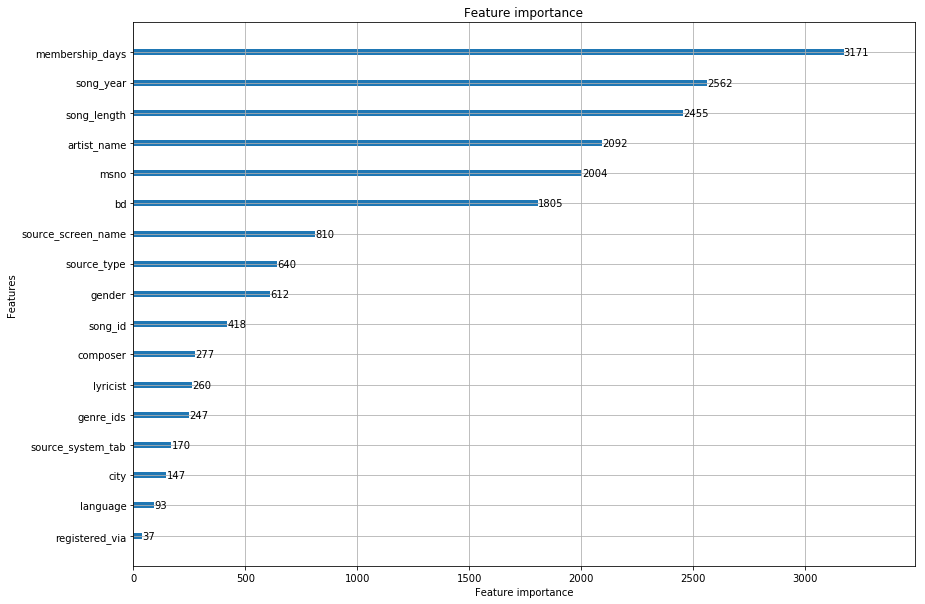

In [58]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')

from lightgbm.plotting import plot_importance


plot_importance(bst, figsize=(14, 10))